# Kalshi Historical Market Data Notebook

Fetch OHLCV candlestick data for any Kalshi market using the public REST API.

> **Note**: This uses Kalshi's public endpoints and does **not** require authentication. Prices are in **cents** (0–100). Not financial advice.


In [19]:
# If needed, install dependencies
%pip install -q requests pandas matplotlib python-dateutil pytz

Note: you may need to restart the kernel to use updated packages.


In [20]:
from __future__ import annotations
import os
import time
import math
import json
import typing as t
from datetime import datetime, timedelta, timezone

import requests
import pandas as pd
from dateutil import parser as dateparser

API_BASE = os.environ.get("KALSHI_API_BASE", "https://api.elections.kalshi.com/trade-api/v2")

def to_unix_ts(x: t.Union[str, datetime]) -> int:
    """Convert a datetime or ISO/date string to UNIX seconds (UTC)."""
    if isinstance(x, (int, float)):
        return int(x)
    if isinstance(x, str):
        # Accept 'YYYY-MM-DD', ISO8601, or relative strings like '-30d'
        s = x.strip()
        if s.startswith("-") and s.endswith("d"):
            days = int(s[1:-1])
            dt = datetime.now(timezone.utc) - timedelta(days=days)
            return int(dt.timestamp())
        dt = dateparser.parse(s)
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
        else:
            dt = dt.astimezone(timezone.utc)
        return int(dt.timestamp())
    if isinstance(x, datetime):
        if x.tzinfo is None:
            x = x.replace(tzinfo=timezone.utc)
        else:
            x = x.astimezone(timezone.utc)
        return int(x.timestamp())
    raise TypeError(f"Unsupported timestamp type: {type(x)}")

def get_json(url: str, params: dict | None = None) -> dict:
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def get_market(market_ticker: str) -> dict:
    url = f"{API_BASE}/markets/{market_ticker}"
    return get_json(url)["market"]

def get_event(event_ticker: str) -> dict:
    url = f"{API_BASE}/events/{event_ticker}"
    return get_json(url)["event"]

def list_markets(series_ticker: str, status: str = "open", limit: int = 100) -> list[dict]:
    url = f"{API_BASE}/markets"
    params = {"series_ticker": series_ticker, "status": status, "limit": limit}
    return get_json(url, params=params).get("markets", [])

def get_market_candles(series_ticker: str, market_ticker: str, start_ts: int, end_ts: int, period_minutes: int = 1440) -> dict:
    if period_minutes not in (1, 60, 1440):
        raise ValueError("period_minutes must be one of 1, 60, or 1440")
    url = f"{API_BASE}/series/{series_ticker}/markets/{market_ticker}/candlesticks"
    params = {"start_ts": start_ts, "end_ts": end_ts, "period_interval": period_minutes}
    return get_json(url, params=params)

def candles_to_df(payload: dict) -> pd.DataFrame:
    c = payload.get("candlesticks", [])
    if not c:
        return pd.DataFrame(columns=[
            "end_period_ts","end_time","yes_bid_open","yes_bid_high","yes_bid_low","yes_bid_close",
            "yes_ask_open","yes_ask_high","yes_ask_low","yes_ask_close",
            "price_open","price_high","price_low","price_close","price_mean","price_previous","price_min","price_max",
            "volume","open_interest","price_close_prob"
        ])
    rows = []
    for row in c:
        end_ts = row.get("end_period_ts")
        end_time = pd.to_datetime(end_ts, unit="s", utc=True)
        price = row.get("price", {})
        yes_bid = row.get("yes_bid", {})
        yes_ask = row.get("yes_ask", {})
        rows.append({
            "end_period_ts": end_ts,
            "end_time": end_time,
            "yes_bid_open": yes_bid.get("open"),
            "yes_bid_high": yes_bid.get("high"),
            "yes_bid_low": yes_bid.get("low"),
            "yes_bid_close": yes_bid.get("close"),
            "yes_ask_open": yes_ask.get("open"),
            "yes_ask_high": yes_ask.get("high"),
            "yes_ask_low": yes_ask.get("low"),
            "yes_ask_close": yes_ask.get("close"),
            "price_open": price.get("open"),
            "price_high": price.get("high"),
            "price_low": price.get("low"),
            "price_close": price.get("close"),
            "price_mean": price.get("mean"),
            "price_previous": price.get("previous"),
            "price_min": price.get("min"),
            "price_max": price.get("max"),
            "volume": row.get("volume"),
            "open_interest": row.get("open_interest"),
            # convenience: convert close price in cents to probability 0-1
            "price_close_prob": (price.get("close") / 100) if price.get("close") is not None else None,
        })
    df = pd.DataFrame(rows).sort_values("end_time").reset_index(drop=True)
    return df

print("Helpers loaded. Base:", API_BASE)

Helpers loaded. Base: https://api.elections.kalshi.com/trade-api/v2


## Configure your target market and time window
- Set `MARKET_TICKER` to the Kalshi **market** ticker (e.g., `KXHIGHNY-2025-10-31-H65`).
- Optionally set `SERIES_TICKER`. If you leave it blank, the notebook will look it up automatically via the market's event.
- Set `START` and `END` as ISO strings (e.g., `"2025-09-01"`) or relative like `"-30d"` for 30 days ago.
- Choose `PERIOD_MINUTES` in `{1, 60, 1440}` (1m / 1h / 1d).

In [21]:
# ---- USER INPUT ----
MARKET_TICKER = "KXHURCTOTMAJ-25DEC01-T4"  # e.g., "KXHIGHNY-2025-10-31-H65"; leave empty to print markets in a series below
SERIES_TICKER = ""  # optional; leave blank to auto-derive from MARKET_TICKER
START = "-4d"      # e.g., "2025-09-01" or relative like "-30d"
END = datetime.now(timezone.utc).strftime("%Y-%m-%d")  # up to today (UTC)
PERIOD_MINUTES = 1  # 1, 60, or 1440

start_ts = to_unix_ts(START)
end_ts = to_unix_ts(END)
print("Window UTC:", datetime.fromtimestamp(start_ts, timezone.utc), "->", datetime.fromtimestamp(end_ts, timezone.utc))

Window UTC: 2025-11-09 23:46:51+00:00 -> 2025-11-13 00:00:00+00:00


In [22]:
# Resolve series_ticker if missing
if SERIES_TICKER:
    series_ticker = SERIES_TICKER.upper()
elif MARKET_TICKER:
    mk = get_market(MARKET_TICKER)
    evt = get_event(mk["event_ticker"])
    series_ticker = evt["series_ticker"]
    print("Derived series_ticker:", series_ticker)
else:
    series_ticker = None
    print("No SERIES_TICKER or MARKET_TICKER provided yet. See the next cell to list markets in a series.")

Derived series_ticker: KXHURCTOTMAJ


### (Optional) Discover markets in a series
If you know a `SERIES_TICKER` (e.g., `KXHIGHNY`), list currently open markets to copy their `MARKET_TICKER`.

In [23]:
if series_ticker:
    mkts = list_markets(series_ticker, status="closed", limit=100)
    if not mkts:
        print(f"No open markets found for series {series_ticker}. Try status='closed' or 'settled'.")
    else:
        print(f"Open markets in series {series_ticker}:")
        for m in mkts:
            print(f"- {m['ticker']}: {m.get('title','')} (yes_bid={m.get('yes_bid')}, yes_ask={m.get('yes_ask')})")
else:
    print("Set SERIES_TICKER above to list markets.")

No open markets found for series KXHURCTOTMAJ. Try status='closed' or 'settled'.


## Fetch candlesticks
This hits `/series/{series_ticker}/markets/{ticker}/candlesticks` with `start_ts`, `end_ts`, and `period_interval`.


In [24]:
assert MARKET_TICKER, "Please set MARKET_TICKER in the input cell above."
assert series_ticker, "Could not resolve SERIES_TICKER. Set it explicitly or set MARKET_TICKER so it can be derived."

payload = get_market_candles(series_ticker, MARKET_TICKER, start_ts, end_ts, PERIOD_MINUTES)
df = candles_to_df(payload)
print(f"Got {len(df)} rows for market {MARKET_TICKER}.")
df.head()

Got 157 rows for market KXHURCTOTMAJ-25DEC01-T4.


,end_period_ts,end_time,yes_bid_open,yes_bid_high,yes_bid_low,yes_bid_close,yes_ask_open,yes_ask_high,yes_ask_low,yes_ask_close,...,price_high,price_low,price_close,price_mean,price_previous,price_min,price_max,volume,open_interest,price_close_prob
0,1762733040,2025-11-10 00:04:00+00:00,6,6,6,6,12,12,12,12,...,NaN,NaN,NaN,NaN,5,None,None,0,20185,NaN
1,1762735920,2025-11-10 00:52:00+00:00,6,6,6,6,12,12,12,12,...,NaN,NaN,NaN,NaN,5,None,None,0,20185,NaN
2,1762738200,2025-11-10 01:30:00+00:00,6,6,6,6,12,12,12,12,...,NaN,NaN,NaN,NaN,5,None,None,0,20185,NaN
3,1762738680,2025-11-10 01:38:00+00:00,6,6,6,6,12,14,12,13,...,14.0,12.0,14.0,13.0,5,None,None,358,20297,0.14
4,1762739700,2025-11-10 01:55:00+00:00,6,6,6,6,13,13,13,13,...,NaN,NaN,NaN,NaN,14,None,None,0,20297,NaN


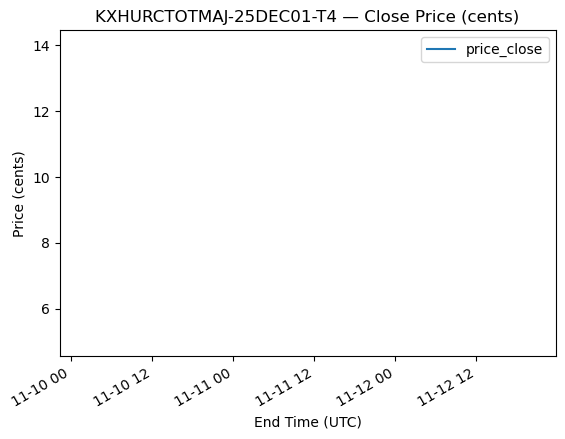

In [25]:
import matplotlib.pyplot as plt
if len(df):
    ax = df.plot(x="end_time", y="price_close", title=f"{MARKET_TICKER} — Close Price (cents)")
    ax.set_xlabel("End Time (UTC)")
    ax.set_ylabel("Price (cents)")
    plt.show()
else:
    print("No candlesticks returned for the selected window.")

In [26]:
# Save to CSV
out_name = f"kalshi_{MARKET_TICKER}_candles_{PERIOD_MINUTES}m.csv".replace("/", "-")
df.to_csv(out_name, index=False)
out_name

'kalshi_KXHURCTOTMAJ-25DEC01-T4_candles_1m.csv'